In [1]:
import pickle
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import requests
from PIL import Image

/home/jose/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-29 10:59:14.581941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 10:59:14.581976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 10:59:14.614067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 10:59:14.682419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimi

In [2]:
# Step 1: Load the dataset
with open('data/dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

Shape: (8, 256, 256, 3)
Data type: uint8


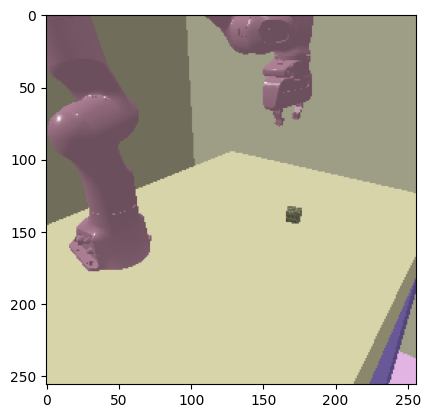

In [3]:
image_data = np.array(dataset["episode_0"][0]["observation"]["front_image"])

print("Shape:", image_data.shape)
print("Data type:", image_data.dtype)

first_image = image_data[0]

# display the first image inline in the notebook
%matplotlib inline

plt.imshow(first_image)


In [4]:

# Step 2: Preprocess the images to extract edges
edges_dataset = []
for episode in dataset.values():
    for observation in episode:
        images = observation["observation"]["front_image"]
        for image in images:
            edges = cv2.Canny(image, 30, 150) # These parameters are: (img, minVal, maxVal), the values refer to the intensity of the edges
            edges = edges[:,:,None]
            edges = np.concatenate([edges, edges, edges], axis=2)
            edges = Image.fromarray(edges)
            edges_dataset.append(edges)

print("Shape:", edges_dataset[0])

Shape: <PIL.Image.Image image mode=RGB size=256x256 at 0x7F36924984C0>


In [5]:
def show_images(im1, im2):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(im2)
    plt.title('Image 2')

    plt.show()

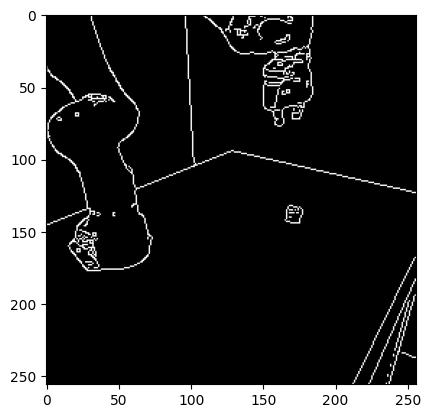

In [6]:
plt.imshow(edges_dataset[0])

In [55]:
from diffusers import EulerDiscreteScheduler

torch.cuda.empty_cache()

#model_id = "stabilityai/stable-diffusion-2"
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda" if torch.cuda.is_available() else "cpu"

# remove current model from cache
if pipe:
    del pipe 
torch.cuda.empty_cache()

# For SD2
#scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
#pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)

# For SD1.5
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)


pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.23.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


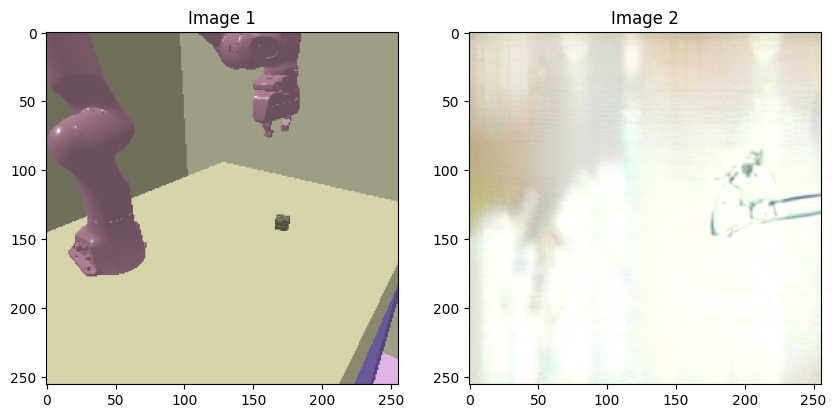

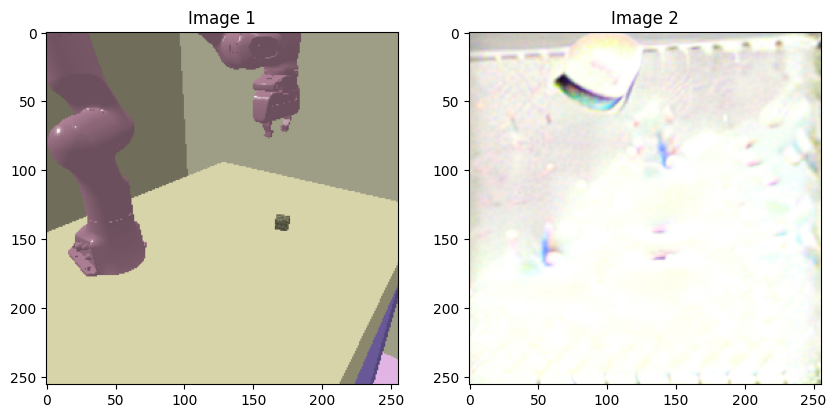

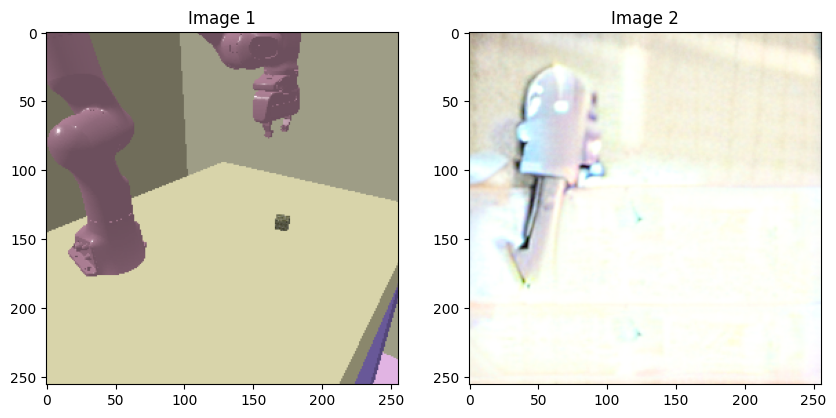

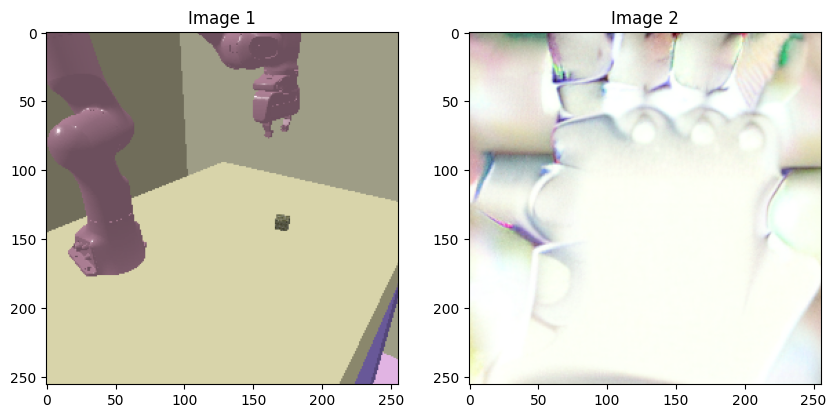

In [64]:
# Step 3: Create image from edges
prompt = "Realistic grey robotic arm anchored to a white table and a small object on the table. White plain background and soft lighting."

result = pipe(prompt = prompt, 
              image = first_image, 
              num_inference_steps=50,
              num_images_per_prompt=4,
              strength=0.5, 
              guidance_scale=3).images


for image in result:
    show_images(first_image, image)

In [49]:
# https://huggingface.co/lllyasviel/sd-controlnet-canny

# remove current model from cache
if pipe:
    del pipe 
torch.cuda.empty_cache()

# For SD2
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

# For SD1.5
#controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-sd21")


pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
    #model_id, controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [51]:
pipe.to(device)
pipe.enable_model_cpu_offload()
torch.backends.cuda.preferred_linalg_library('magma')

<_LinalgBackend.Magma: 2>

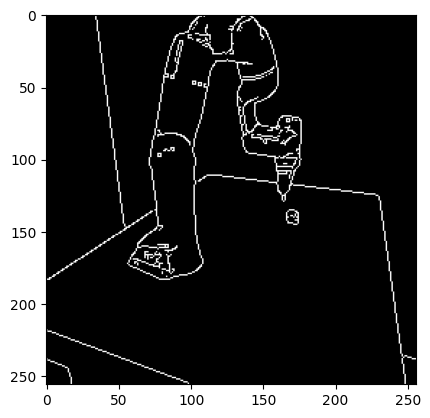

In [52]:
plt.imshow(edges_dataset[20])

100%|██████████| 50/50 [00:08<00:00,  6.22it/s]


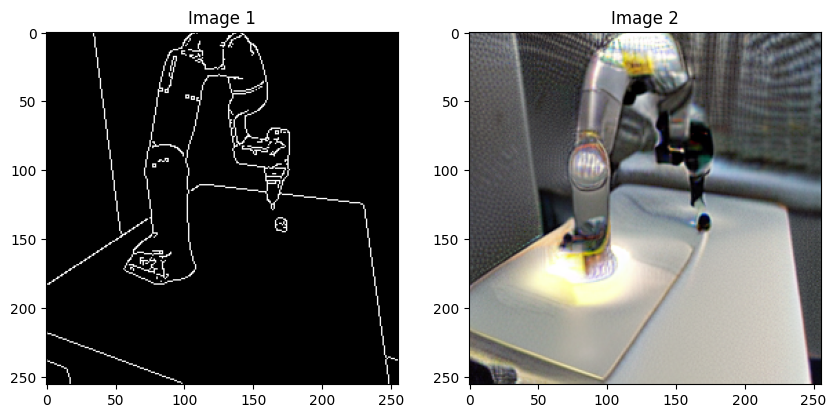

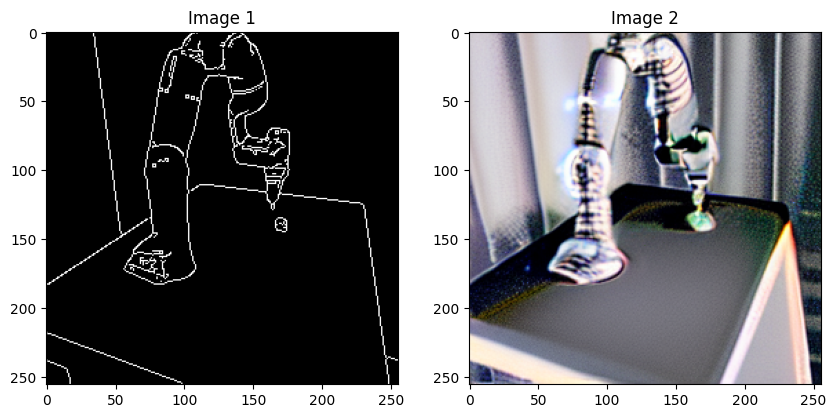

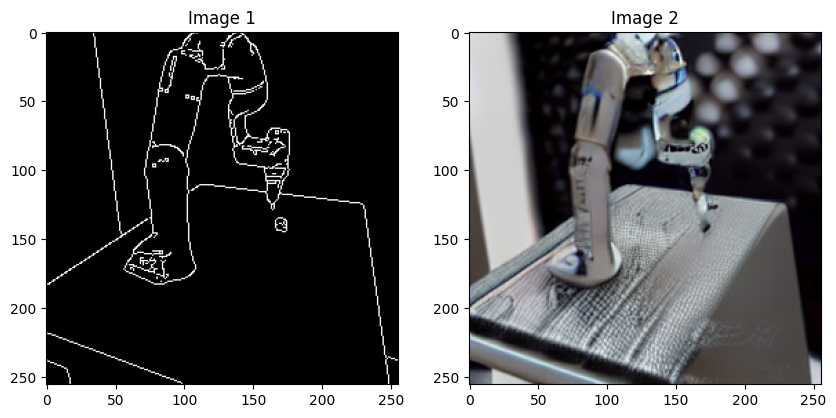

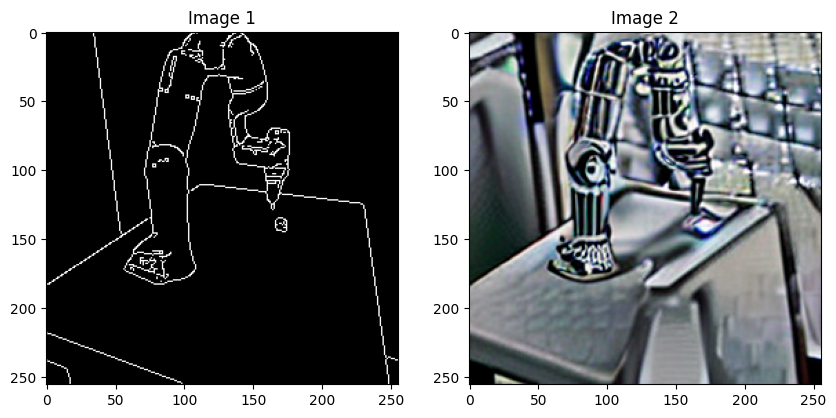

In [54]:
prompt = "Realistic grey robotic arm anchored to a white table and a small object on the table. White plain background and soft lighting."

neg_prompt = "colors, reflections"

images = pipe(prompt, 
             edges_dataset[20], 
             negative_prompt=neg_prompt, 
             num_inference_steps=50, 
             num_images_per_prompt=4,
             guidance_scale=4).images

for im in images:
    show_images(edges_dataset[20], im)


In [39]:
# https://huggingface.co/lllyasviel/sd-controlnet-mlsd

# remove current model from cache
if pipe:
    del pipe 
torch.cuda.empty_cache()

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MLSDdetector

mlsd = MLSDdetector.from_pretrained('lllyasviel/ControlNet')

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-mlsd", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()


/home/jose/.local/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/p

100%|██████████| 50/50 [00:08<00:00,  6.19it/s]


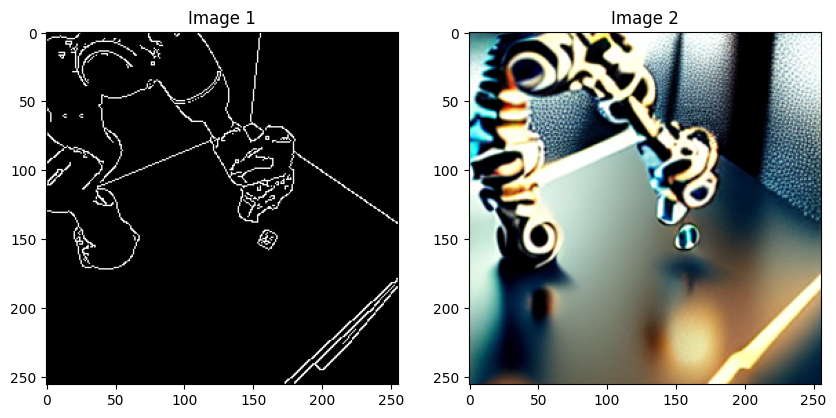

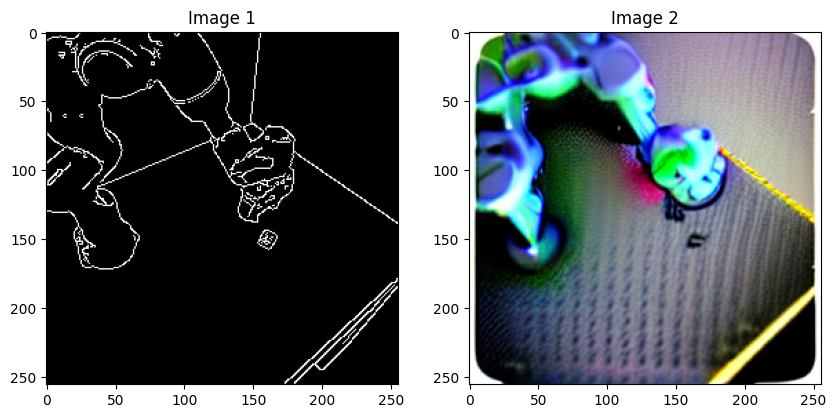

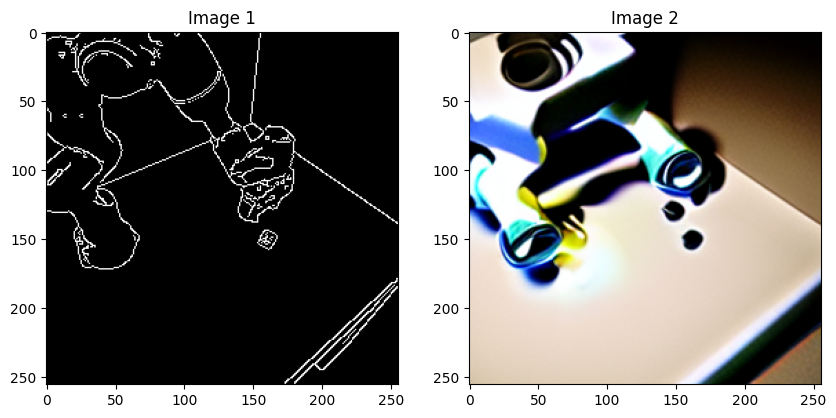

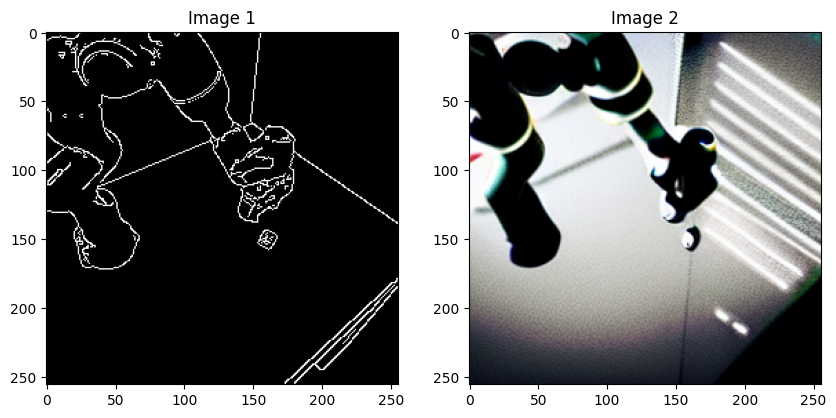

In [48]:
prompt = "Realistic grey robotic arm anchored to a white table and a small object on the table. White plain background and soft lighting."
neg_prompt = "lights, textures"
edge = edges_dataset[17]

images = pipe(prompt, 
             edge, 
             num_inference_steps=50,
             #negative_prompt=neg_prompt,
             num_images_per_prompt=4
             ).images

for image in images:
    show_images(edge, image)

In [33]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

image = depth_estimator(first_image)['predicted_depth'][0]


RuntimeError: "LayerNormKernelImpl" not implemented for 'Half'